<h2>1. Importing modules </h2>

Pandas is required in order to manage the dataframe
Numpy is used to handle numpy arrays
os and path are used to access particular files

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from IPython.display import Markdown

<h2>2. Designating significance of smartphone events and apps</h2>

Designate the significance of particular events. This is subject to change with the functioning of android. Please specify what events are import (to be included in the analysis) and what events constitutes being activiely engaged with the phone. Additionally, group the genera of apps that will be encountered. 

In [3]:
#From https://android.googlesource.com/platform/frameworks/base/+/master/core/java/android/app/usage/UsageEvents.java
eventNumToDetails = {
    0: "none",
    1: "move to foreground",
    2: "move to background",
    3: "End of day",
    4: "Continue previous day",
    5: "Configuration change",
    6: "System interaction",
    7: "User interaction",
    8: "Shortcut invocation",
    9: "Chooser action",
    10: "Notification seen",
    11: "Standby buncket changed",
    12: "Notification interuption",
    13: "SLICE_PINNED_PRIV",
    14: "SLICE_PINNED_PRIV",
    15: "Screen interactive",
    16: "Screen non interactive",
    17: "keyguard shown",
    18: "keyguard hidden",
    19: "Foreground service start",
    20: "Foreground service stopped",
    21: "Continuing foreground service",
    22: "Rollover foreground service",
    23: "Activity stopped",
    24: "Activity destoryed",
    25: "Flush to disk",
    26: "Device shutdown",
    27: "Device start up"}
#Important events determine everything that the period is established from one of these points to the next event
importantEvents = [1,2, 7, 26,27]
#Active events are those which are considered to be linked to screen time. 
activeEvents = [1,7]

#The estimated duration that a person is using a single app before it is assumed that the user left their phone on. 
tooLong = 60*60*2


<h2>3. Importing, Cleaning and describing the data </h2>

Going through the data frame to remove any data points that can be merged. So that events that have less than a second when the app was in the background and it is ultimately within the same second. There are three stages of cleaning:
<ol>
    <li>Remove all events which are not included in the important events</li>
    <li>Remove all events which are unnecessarily intercepted by a move_to_background event</li>
    <li>Remove all events which are a duplicate of the one that comes before</li>
    <li>Remove all background events which lasted a second</li>    
</ol>

Description of the data will include:
<ol>
    <li> The duration of monitoring that has occured</li>
    <li>The duration spent using the smartphone device</li>
    <li>The duration which each type of genera has been employed.</li>

</ol>

In [15]:
#functions for data cleaning

def cleaning1 (data):
    toDrop = []
    toDrop = data[~data['Event'].isin(importantEvents)].index
    data.drop(toDrop, inplace=True)
    data.index = range(len(data))
    return data

def cleaning2 (data):
    toDrop = []
    for i in range(len(data)):
        if data.Event[i] == 2 and (i+1) < len(data):
            if (data.Unix[i] == data.Unix[i+1] and data.App[i] == data.App[i+1]):
                if (i-1) > 0 :
                    if data.Event[i-1] == data.Event[i+1]:
                        toDrop.append(i)
                        toDrop.append(i+1)
                    else:
                        toDrop.append(i)
    data.drop(toDrop, inplace=True)
    data.index = range(len(data))
    return data

def cleaning3(data):
    toDrop = []
    for i in range(len(data)-2):
        if data.App[i] == data.App[(i+1)] and data.App[i] == data.App[(i+2)]:
            if (data.Event[i] == 1 or data.Event[i] == 7) and (data.Event[(i+1)] == 1 or data.Event[(i+1)] == 7)  and (data.Event[(i+2)] == 1 or data.Event[(i+2)] == 7):
                toDrop.append((i+1))
                toDrop.append((i+2))
    data.drop(toDrop, inplace=True)
    data.index = range(len(data))
    
    return data

def cleaning4(data, tooLong):
    toDrop = []
    for i in range(len(data)):
        if data.Event[i] == 2 and data.duration[i] == 0:
            toDrop.append(i)
        if data.Event[i] != 2 and data.duration[i] > tooLong:
            toDrop.append(i)
            
    data.drop(toDrop, inplace=True)
    data.index = range(len(data))
    return data


def cleaning(data, printChanges):
    if printChanges:
        print("initialy the amount of rows in the dataframe was: ", len(data))
    data = cleaning1(data.copy())
    if printChanges:
        print("after cleaning stage1 the amount of rows in the dataframe was: ", len(data))
    data = cleaning2(data.copy())
    if printChanges:
        print("after cleaning stage2 the amount of rows in the dataframe was: ", len(data))    
    data = cleaning3(data.copy())
    if printChanges:
        print("after cleaning stage3 the amount of rows in the dataframe was: ", len(data))
        
    duration = []
    for i in range(len(data) -1):
        duration.append(data.iloc[1+i]['Unix'] - data.iloc[i]['Unix'])
    duration.append(0)
    data.insert(4, "duration", duration)
        
    data = cleaning4(data.copy(), tooLong)
    if printChanges:
        print("after whole cleaning the amount of rows in the dataframe were: ", len(data))
    return data



<h2>Cleaning past usage data</h2>

This will occur in a number of steps:

<ol>
    <li>Exclude unimportant events</li>
    <li>remove duplicates of the same event</li>
    <li>Combine multiple form of interaction at the same time</li>
    <p><b>Then the script must establish the duration of usage events</b></p>
    <li>remove events which are bizzarly long or events that lasted less than a second</li>
</ol>



In [18]:
df = pd.read_csv("past usage.csv")
df = df.drop(columns = ['Unnamed: 3'])
df.columns = ["Unix", "App", "Event"]

df.Unix = df.Unix.astype("int")
df.Unix = df.Unix / 1000
df.Unix = df.Unix.astype("int")
df.Event = df.Event.astype("int")

df['rEvent'] =  [eventNumToDetails.get(i, "unanticipated event") for i in df.Event]

df = cleaning(df, True)
print(df)

initialy the amount of rows in the dataframe was:  3425
after cleaning stage1 the amount of rows in the dataframe were:  1184
after cleaning stage2 the amount of rows in the dataframe were:  844
after cleaning stage3 the amount of rows in the dataframe were:  832
after whole cleaning the amount of rows in the dataframe were:  566
           Unix           App  Event              rEvent  duration
0    1571151207      WhatsApp      1  move to foreground         5
1    1571151212      WhatsApp      1  move to foreground         4
2    1571151216      WhatsApp      2  move to background       700
3    1571151916      WhatsApp      1  move to foreground       970
4    1571152886      WhatsApp      1  move to foreground        19
..          ...           ...    ...                 ...       ...
561  1571236273  Usage Logger      1  move to foreground        19
562  1571236292      Settings      1  move to foreground         2
563  1571236294  Usage Logger      1  move to foreground         

<h2>Establishing variables</h2>

<h3>Screen usage</h3>
This is established through excluding all screen off events and the summing the duration. 

Then, establihing the different usage rates per day

In [6]:
df["dateTime"] = [datetime.fromtimestamp(time) for time in df.Unix]
screenOn = df[df.Event != 2]

durationScreenUsed = sum(screenOn.duration)
#print("total usage:", durationScreenUsed/60/60, "(in hours)")

screenOn["days"] = [datetime.fromtimestamp(time).day for time in screenOn.Unix]

#now investigating it per day
for aDay in  screenOn.days.unique():
    dayDF = screenOn[screenOn.days == aDay]
    print("on day:",str(dayDF.dateTime[dayDF.index[0]])[0:10] + "phone was used for a duration of: " + str(sum(dayDF.duration)/60/60))


on day: 2019-10-15phone was used for a duration of: 2.036111111111111
on day: 2019-10-16phone was used for a duration of: 5.121944444444444


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<h3>Establishing top used apps</h3>
This is done by creating a new dataframe for each of the apps and then summing up the duration which they were used. 

In [7]:
uniqueApps = df.App.unique()
timeAppUsed = pd.DataFrame(columns = ["App", "Duration"])

for app in uniqueApps:
    appDf = df[df.App == app]
    appDf = appDf[appDf.Event != 2]
    lenAppUsed = len(timeAppUsed)
    timeAppUsed.at[lenAppUsed, "App"] = app
    timeAppUsed.at[lenAppUsed, "Duration"] = sum(appDf.duration)/60/60
    
timeAppUsed = timeAppUsed.sort_values(by=['Duration'], ascending=False)
timeAppUsed.index = range(len(timeAppUsed))
print(timeAppUsed)


                     App     Duration
0              Quickstep      1.97139
1           Usage Logger      1.81333
2                Audible     0.739167
3              Polytopia     0.611667
4                YouTube     0.563611
5               WhatsApp     0.518056
6                 Chrome         0.39
7                 TikTok     0.261389
8                  Phone         0.07
9               Settings    0.0683333
10              Checkers    0.0669444
11              Messages    0.0447222
12                 Gmail   0.00833333
13     Google Play Store       0.0075
14     Package installer   0.00666667
15                Any.do   0.00638889
16            Keep notes   0.00638889
17        Android system   0.00166667
18                Camera   0.00166667
19  Stickman Dismounting  0.000833333


<h1>Integrating context</h1>

Adding the context to provide information about usage. 

In the following example, we will review how many apps which are permitted to access the user's location are used of the course of the day. 

Finally, seeing the duration of usage for location enable apps across the two days

In [8]:
context = pd.read_csv("context.csv")
context = context.drop(columns = ['Unnamed: 3'])
context.columnsc = ["app", "permission", "response"]

#ensuring that context only reflects location detecting apps
context = context[context["permission"] == "android.permission.ACCESS_FINE_LOCATION"]
context = context[context["response"] == True]

locationSensingApps = context.app.values

locationDF = screenOn[screenOn["App"].isin(locationSensingApps)]
print("duration of usage across the two days for location sensing apps:", sum(locationDF.duration)/60/60)

duration of usage across the two days for location sensing apps: 0.976388888888889


<h1>Visualsisations</h1>

The visualisations will include three different visualisations:

<ol>
    <li>A monochrome time based bar code of when the smartphone was on</li>
    <li>A coloured time based code of when the top five used apps (of that day) were eployed</li>
    <li>A monochrome time based bar code of when the location sensing apps were employed </li>
</ol>


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


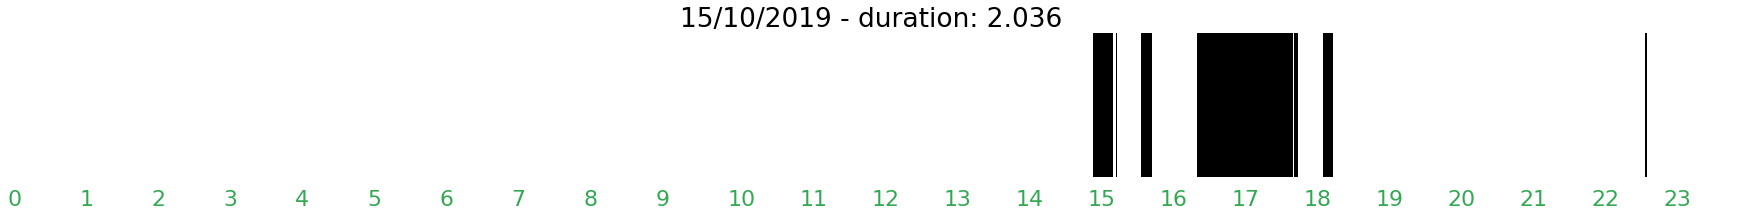

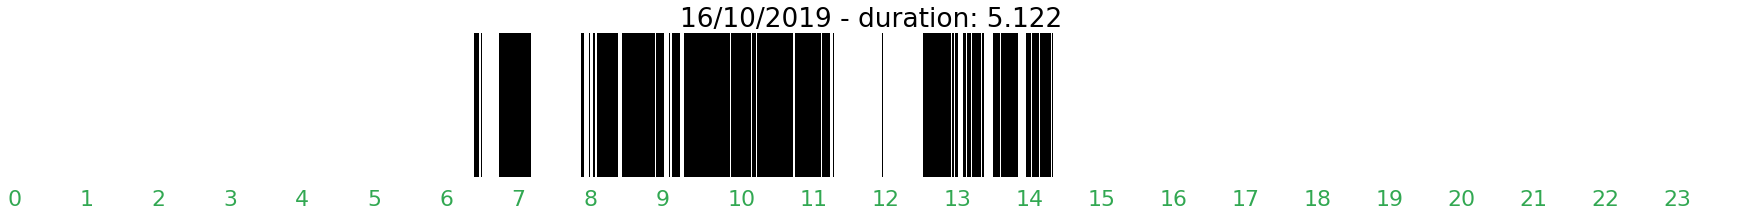

In [10]:
df["dateTime"] = [datetime.fromtimestamp(time) for time in df.Unix]
df["days"] = [datetime.fromtimestamp(time).day for time in df.Unix]

dayData = [df[df["days"] == day] for day in df.days.unique()]

## pd.set_option('mode.chained_assignment', None)

for day in dayData:

    day.index = range(len(day))
    sec = []

    day["duration"] = day["duration"].astype(int)

    midnight = day.dateTime[0].replace(hour=0, minute=0, second=0, microsecond=0)
    midnight = midnight.timestamp()
    
    durationOfEvent = 0

    for i in range(60*60*24):
        
        currentTime = int(midnight+i)
        if durationOfEvent < 3:
            if (currentTime == day.Unix).any():
                currentRow = day[day["Unix"] == currentTime]
                if currentRow.Event[currentRow.index[0]] != 2:
                    durationOfEvent = currentRow.duration[currentRow.index[0]]

        if durationOfEvent > 0:
            sec.append(True)
            durationOfEvent-=1
        else:
            sec.append(False)
            
    barprops = dict(aspect="auto", cmap="binary", interpolation = "nearest")
    fig = plt.figure()
    plt.rcParams.update({'font.size': 22})

    ax = fig.add_axes([1,1,4,.5])
    ax.set_axis_off()
    sec = np.asarray(sec)
    for hour in range(24):

        ax.text(x = (len(sec)/24)*hour, y = .7, s = hour, color="#32a852" )

    ax.imshow(sec.reshape((1,-1)), **barprops)

    spent = round(sum(day[day["Event"] != 2]["duration"]/60/60),3)
    title = str(day.dateTime[0].day) + "/" + str(day.dateTime[0].month) + "/" + str(day.dateTime[0].year) 
    plt.title(str(title) + " - duration: " + str(spent))

    plt.show()

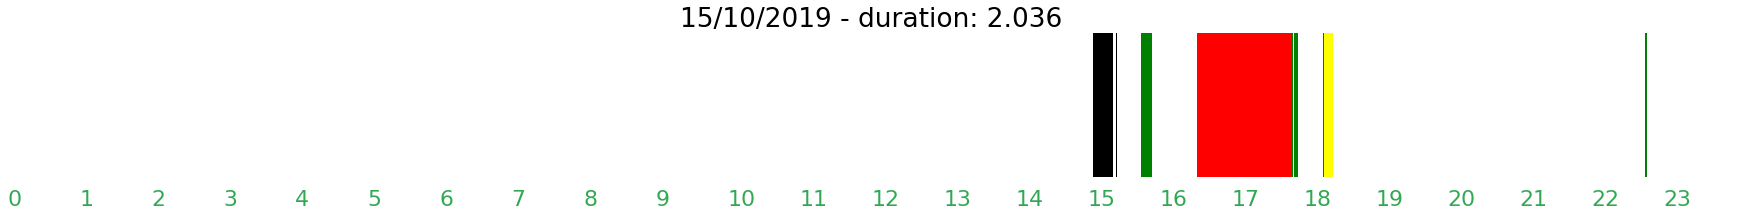

WhatsApp is coloured as <span style="color:black">black</span>.

Quickstep is coloured as <span style="color:red">red</span>.

TikTok is coloured as <span style="color:green">green</span>.

YouTube is coloured as <span style="color:yellow">yellow</span>.

Google Play Store is coloured as <span style="color:blue">blue</span>.

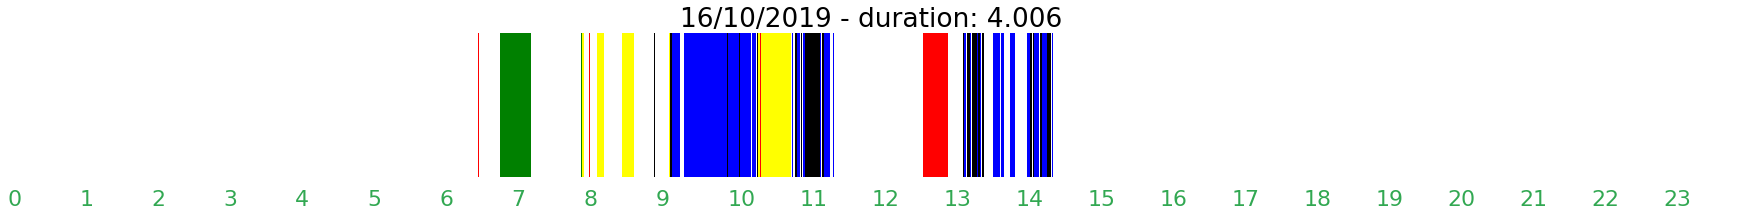

Quickstep is coloured as <span style="color:black">black</span>.

Chrome is coloured as <span style="color:red">red</span>.

YouTube is coloured as <span style="color:green">green</span>.

Audible is coloured as <span style="color:yellow">yellow</span>.

Usage Logger is coloured as <span style="color:blue">blue</span>.

In [11]:
df["dateTime"] = [datetime.fromtimestamp(time) for time in df.Unix]
df["days"] = [datetime.fromtimestamp(time).day for time in df.Unix]

dayData = [df[df["days"] == day] for day in df.days.unique()]

pd.set_option('mode.chained_assignment', None)
for day in dayData:
    employedApps = ["not an app"]
    
    appDuration =  pd.DataFrame(columns = ["app", "duration"])
    
    for app in day.App.unique():
        onlyApp = day[day["App"] == app]
        lenApp = len(appDuration)
        appDuration.at[lenApp, "app"] = app
        appDuration.at[lenApp, "duration"] = sum(onlyApp.duration)
    
    appDuration = appDuration.sort_values(by=['duration'], ascending=False)
    
    appDuration = appDuration.iloc[:5]
        
    day = day[day.App.isin(appDuration.app)]
    
    day.index = range(len(day))
    sec = []

    day["duration"] = day["duration"].astype(int)

    midnight = day.dateTime[0].replace(hour=0, minute=0, second=0, microsecond=0)
    midnight = midnight.timestamp()
    
    durationOfEvent = 0
    typeOfEvent = 0

    for i in range(60*60*24):
        
        currentTime = int(midnight+i)
        if durationOfEvent < 3:
            if (currentTime == day.Unix).any():
                currentRow = day[day["Unix"] == currentTime]
                if currentRow.Event[currentRow.index[0]] != 2:
                    durationOfEvent = currentRow.duration[currentRow.index[0]]
                    currentApp = currentRow.App[currentRow.index[0]]
                    if currentApp not in  employedApps:
                        employedApps.append(currentApp)
                        
                    typeOfEvent = employedApps.index(currentApp)

        if durationOfEvent > 0:
            sec.append(typeOfEvent)
            durationOfEvent-=1
        else:
            sec.append(0)
            
    
    colors = ListedColormap(["white","black", "red", "green","yellow","blue"])

    barprops = dict(aspect="auto", cmap=colors)
    fig = plt.figure()
    plt.rcParams.update({'font.size': 22})

    ax = fig.add_axes([1,1,4,.5])
    ax.set_axis_off()
    sec = np.asarray(sec)
    for hour in range(24):
        ax.text(x = (len(sec)/24)*hour, y = .7, s = hour, color="#32a852" )

    ax.imshow(sec.reshape((1,-1)), **barprops)

    spent = round(sum(day[day["Event"] != 2]["duration"]/60/60),3)
    title = str(day.dateTime[0].day) + "/" + str(day.dateTime[0].month) + "/" + str(day.dateTime[0].year) 
    plt.title(str(title) + " - duration: " + str(spent))

    theDay = day.days.unique()
    
    plt.show()    

    for i in range(len(employedApps)):
        if employedApps[i] != "not an app":
            display (Markdown(str(employedApps[i]) +  ' is coloured as <span style="color:' + colors.colors[i]+'">' + colors.colors[i] +'</span>.'))
    

55
15


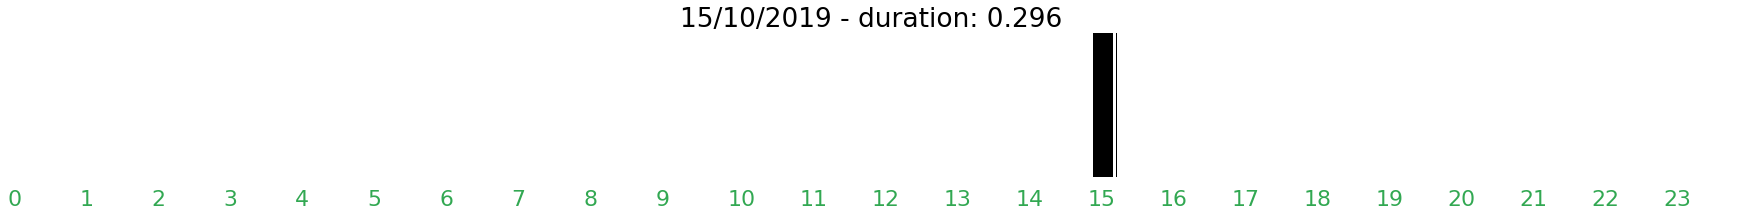

511
121


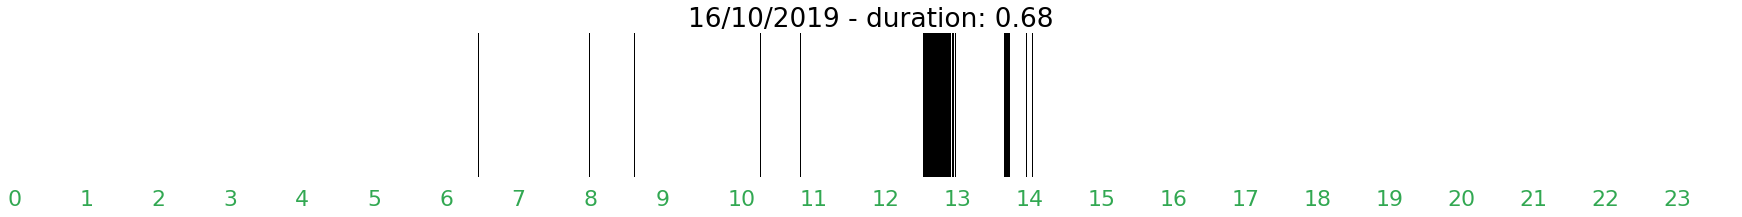

In [12]:
df["dateTime"] = [datetime.fromtimestamp(time) for time in df.Unix]
df["days"] = [datetime.fromtimestamp(time).day for time in df.Unix]

dayData = [df[df["days"] == day] for day in df.days.unique()]

## pd.set_option('mode.chained_assignment', None)

for day in dayData:
    
    print(len(day))
    day = day[day["App"].isin(locationSensingApps)]
    print(len(day))

    day.index = range(len(day))
    sec = []

    day["duration"] = day["duration"].astype(int)

    midnight = day.dateTime[0].replace(hour=0, minute=0, second=0, microsecond=0)
    midnight = midnight.timestamp()

    for i in range(60*60*24):
        
        currentTime = int(midnight+i)
        if durationOfEvent < 3:
            if (currentTime == day.Unix).any():
                currentRow = day[day["Unix"] == currentTime]
                if currentRow.Event[currentRow.index[0]] != 2:
                    durationOfEvent = currentRow.duration[currentRow.index[0]]

        if durationOfEvent > 0:
            sec.append(True)
            durationOfEvent-=1
        else:
            sec.append(False)
            
    barprops = dict(aspect="auto", cmap="binary", interpolation = "nearest")
    fig = plt.figure()
    plt.rcParams.update({'font.size': 22})

    ax = fig.add_axes([1,1,4,.5])
    ax.set_axis_off()
    sec = np.asarray(sec)
    for hour in range(24):

        ax.text(x = (len(sec)/24)*hour, y = .7, s = hour, color="#32a852" )

    ax.imshow(sec.reshape((1,-1)), **barprops)

    spent = round(sum(day[day["Event"] != 2]["duration"]/60/60),3)
    title = str(day.dateTime[0].day) + "/" + str(day.dateTime[0].month) + "/" + str(day.dateTime[0].year) 
    plt.title(str(title) + " - duration: " + str(spent))

    plt.show()
